In [1]:
from multi_nutrient_model import competitive_oxidation, ref_parameters, REF_STEADY_STATE_VALUES
import scipy.optimize as opt
import numpy as np


In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 10, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 5, 'capthick': 2, 'elinewidth': 2, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['lightsteelblue', 'steelblue']

# Colors to highlight metabolites
# Glucose, lactate, 3HB, Fatty acids
colors_met = ['firebrick', 'lightcoral', 'gold' ,  'wheat',]

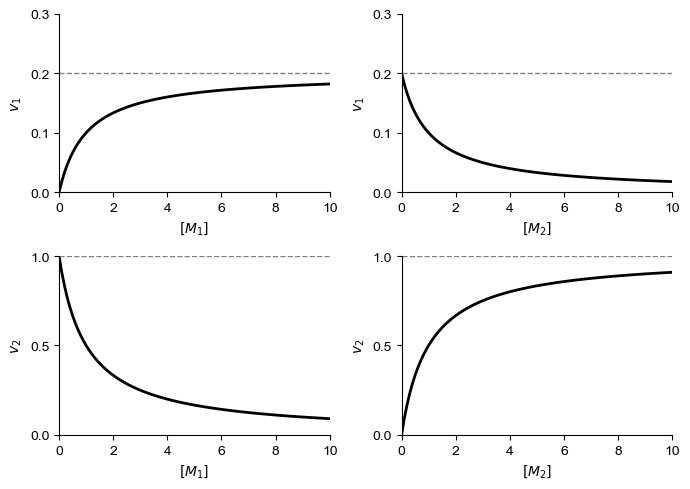

In [3]:
# Make an illutrative figure of a two nutrient comptiation system 
import numpy as np


def v1(M1,M2):
    a1 = 5
    a2 = 1
    return 0.1 * M1 / (0.1*a1*M1 + 0.5*a2*M2) 

def v2(M1,M2):
    a1 = 5
    a2 = 1
    return 0.5 * M2 / (0.1*a1*M1 + 0.5*a2*M2)


# Plot v1 as a function of M1 and M2
M1 = np.linspace(0, 10, 100)
M2 = np.linspace(0, 10, 100)

# one variable fixes
v1_M1_fixed = v1(M1, 1)
v1_M2_fixed = v1(1, M2)

v2_M1_fixed = v2(M1, 1)
v2_M2_fixed = v2(1, M2)

# Plot the results side by side
fig, ax = plt.subplots(2,2,figsize=(7, 5))
ax[0,0].plot(M1, v1_M1_fixed, color='black', linewidth=2)
ax[0,0].set_xlabel('$[M_1]$')
ax[0,0].set_ylabel('$v_1$')
# Add horizontal line at v1 = 1/a1 = 0.2
ax[0,0].axhline(0.2, color='grey', linestyle='--', linewidth=1)


ax[0,1].plot(M2, v1_M2_fixed, color='black', linewidth=2)
ax[0,1].set_xlabel('$[M_2]$')
ax[0,1].set_ylabel('$v_1$')
# Add horizontal line at v1 = 1/a2 = 1
ax[0,1].axhline(0.2, color='grey', linestyle='--', linewidth=1) 

# adjust x and y limits and ticks
ax[0,0].set_xlim(0, 10)
ax[0,0].set_ylim(0, 0.3)
ax[0,0].set_yticks([0, 0.1, 0.2, 0.3])
ax[0,1].set_xlim(0, 10)
ax[0,1].set_ylim(0, 0.3)
ax[0,1].set_yticks([0, 0.1, 0.2, 0.3])

ax[1,0].plot(M1, v2_M1_fixed, color='black', linewidth=2)
ax[1,0].set_xlabel('$[M_1]$')
ax[1,0].set_ylabel('$v_2$')
# Add horizontal line at v2 = 1/a1 = 0.2
ax[1,0].axhline(1, color='grey', linestyle='--', linewidth=1)
ax[1,0].set_xlim(0, 10)
ax[1,0].set_ylim(0, 1)
ax[1,0].set_yticks([0, 0.5, 1]) 

ax[1,1].plot(M2, v2_M2_fixed, color='black', linewidth=2)
ax[1,1].set_xlabel('$[M_2]$')
ax[1,1].set_ylabel('$v_2$')
# Add horizontal line at v2 = 1/a2 = 1
ax[1,1].axhline(1, color='grey', linestyle='--', linewidth=1) 
ax[1,1].set_xlim(0, 10)
ax[1,1].set_ylim(0, 1)
ax[1,1].set_yticks([0, 0.5, 1])


# Adjust layout
plt.tight_layout()
sns.despine()


# Save figure
plt.savefig('output/illustrative_figure_two_nutrient_competition.svg', format='svg', bbox_inches='tight')
plt.show()

In [4]:
# Insulin secretion
k = 3.4
C = 2.3

#Ref. insulin
Imax = 1.0
I0 = abs(1.0)**k / (abs(1.0)**k + C**k)

p = ref_parameters()    

# Reference concentrations
# L, G, F, K, I
x0 = np.array([1, 1, 1, 1, I0])
v0 = competitive_oxidation(x0, p)

In [5]:
# Vary each concentration by 4 fold up and down and calculate the corresponding oxidation rates

# Oxidation rates 
rate_names = ['Lactate', 'Glucose', 'Fatty acids', 'Ketones','Glycolysis']

X = np.logspace(-2, 2, 201)

results = {}

h_g = 1.0
h_f = 1.0
h_l = 1.0
h_k = 1.0

# Glucose
results['Glucose'] = []
for xi in X:
    x = x0.copy()
    x[1] = xi
    v = competitive_oxidation(x, p,)
    results['Glucose'].append({n:v[j] for j,n in enumerate(rate_names)})

# Lactate
results['Lactate'] = []
for xi in X:
    x = x0.copy()
    x[0] = xi
    v = competitive_oxidation(x, p, )
    results['Lactate'].append({n:v[j] for j,n in enumerate(rate_names)})

# Fatty acids
results['Fatty acids'] = []
for xi in X:
    x = x0.copy()
    x[2] = xi

    v = competitive_oxidation(x, p, )
    results['Fatty acids'].append({n:v[j] for j,n in enumerate(rate_names)})

# Ketones
results['Ketones'] = []
for xi in X:
    x = x0.copy()
    x[3] = xi
    v = competitive_oxidation(x, p,)
    results['Ketones'].append({n:v[j] for j,n in enumerate(rate_names)})

In [6]:
# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2200*0.8
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 

In [7]:
order_cols = ['Glucose','Lactate', 'Fatty acids', 'Ketones']
order_rows = ['Glycolysis','Glucose', 'Lactate', 'Fatty acids', 'Ketones']


scaling = {'Glucose': 6, 'Lactate': 3, 'Fatty acids': 16, 'Ketones': 4, 'Glycolysis': 6}

In [8]:
# Save the data for the lines into a csv file

data_to_save = {}
for j, met in enumerate(order_cols):
    for i, rate in enumerate(order_rows):
        data = results[met]
        r = np.array([d[rate] for d in data])  * vE  * scaling[rate] / 1000
        # add oxiation to rate name if not glycolysis
        if rate != 'Glycolysis':
            rate = rate + ' oxidation'
        data_to_save[(met,rate)] = r
        
df = pd.DataFrame(data_to_save, index=X)

# metl the data frame
df = df.melt(ignore_index=False, var_name=['Metabolite', 'Rate'], value_name='Rate (mmol/min/gBW)')

# Name index to 'Concentration relative to reference'
df.index.name = 'Concentration relative to reference'
# Save the data frame to a csv file
df.to_csv('./output/competitive_catabolism_rates.csv')

In [9]:
df

,Metabolite,Rate,Rate (mmol/min/gBW)
Concentration relative to reference,,,
0.010000,Glucose,Glycolysis,0.005847
0.010471,Glucose,Glycolysis,0.006123
0.010965,Glucose,Glycolysis,0.006411
0.011482,Glucose,Glycolysis,0.006713
0.012023,Glucose,Glycolysis,0.007028
...,...,...,...
83.176377,Ketones,Ketones oxidation,1.394880
87.096359,Ketones,Ketones oxidation,1.401718
91.201084,Ketones,Ketones oxidation,1.408311


In [10]:
# Load concentration data from perubative infusions
df = pd.read_csv('./data/perturbative_concentration_data.csv')

# Rename Trcers and compounds
rename_dict = { '3-hydroxybutyrate': '3HB', 
               'glucose': 'Glucose', 'lactate': 'Lactate', }

# Rename values in columns COMPOUND and TRACER
df['COMPOUND'] = df['COMPOUND'].replace(rename_dict)
df['TRACER'] = df['TRACER'].replace(rename_dict)

# Average over commpound == c16:0 , c18:2 and c18:1 --> fatty acids
mapping_dict = {'c16:0': 'Fatty acids', 'c18:2 ': 'Fatty acids', 'c18:1': 'Fatty acids'} 
df['COMPOUND'] = df['COMPOUND'].replace(mapping_dict)

df = df.groupby(['TRACER', 'COMPOUND' ,'CAGE','DAY']).mean().reset_index()


In [11]:
# Fcric data 
df_fcirc = pd.read_csv('./data/perturbative_fcirc_data.csv')

# Rename Trcers and compounds
rename_dict = { '3-hydroxybutyrate': '3HB', 
               'glucose': 'Glucose', 'lactate': 'Lactate', }
# Rename values in columns COMPOUND and TRACER
df_fcirc['COMPOUND'] = df_fcirc['COMPOUND'].replace(rename_dict)
df_fcirc['TRACER_x'] = df_fcirc['TRACER_x'].replace(rename_dict)



In [12]:
# Plot concentration change against fluxes
df_joined = df.merge(df_fcirc, left_on=['TRACER', 'COMPOUND','CAGE','TIME','DAY'], 
                     right_on=['TRACER_x', 'COMPOUND','CAGE','TIME','DAY'], how='inner')

In [13]:
# Rescale concentration by mean level of respective metabolite

concentration_scaling = {'Glucose':5.5, 'Lactate':0.7, "3HB":0.5}

df_joined['concentration_mM'] = df_joined.apply(lambda x: x['value_normalized'] * concentration_scaling[x['COMPOUND']] ,axis=1)

concentration_scaling = {'Glucose':5.5, 'Lactate':0.7, "Ketones":0.5}


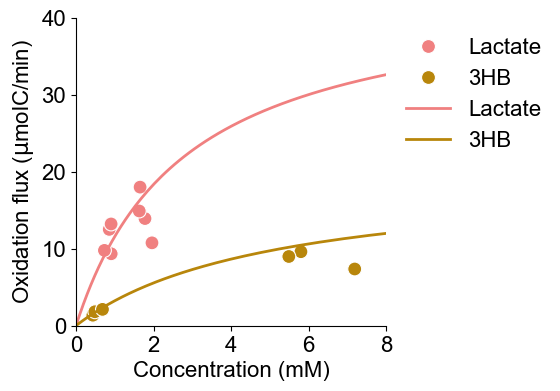

In [14]:
# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})

colors_met = [ 'lightcoral', 'darkgoldenrod',]

# Rename labels glucose, lactate, 3HB
order = [ 'Lactate', '3HB', ] 

df_joined_temp = df_joined[df_joined['COMPOUND'].isin(order)]

# Scatter plot of delta RD and delta CO2 flux
f, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(data=df_joined_temp, x='concentration_mM', y='CO2_FLUX_NORM' ,
                hue='COMPOUND', 
                palette=colors_met, s=100, hue_order=order, )
# Plot the model 

order = ['Lactate', 'Ketones', ]


for i, met in enumerate(order):
    # Get the data for the current metabolite
    data = results[met]
    if met == 'Glucose':
        # Plot the model
        r1 = np.array([d[met] for d in data])  * vE  * scaling[met] / 1000 * 25
        r2 = np.array([d['Glycolysis'] for d in data])  * vE  * scaling['Glycolysis'] / 1000 * 25
        ax.plot(X * concentration_scaling[met], r1 + r2, color=colors_met[i],  linewidth=2, label='Glycolysis & \nGlucose oxidation')

    elif met == 'Ketones':
        # Plot the model
        r = np.array([d[met] for d in data])  * vE  * scaling[met] / 1000 * 25
        ax.plot(X * concentration_scaling[met], 0.5 * r, color=colors_met[i],  linewidth=2, label='3HB',)
        #ax.plot(X, r*0.5, color=colors_met[i],  linewidth=2, linestyle='--', )

    else:
        # Plot the model
        r = np.array([d[met] for d in data])  * vE  * scaling[met] / 1000 * 25
        ax.plot(X * concentration_scaling[met], r, color=colors_met[i],  linewidth=2, label=met)

plt.ylim(0, 40)
plt.xlim(0, 8)

sns.despine()
#plt.xscale('log')
plt.xlabel('Concentration (mM)')
plt.ylabel('Oxidation flux ($\mathrm{\mu}$molC/min)')

plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.savefig('./output/concentration_CO2_flux_ketone_lactate.svg',  bbox_inches='tight')

# Save the data 

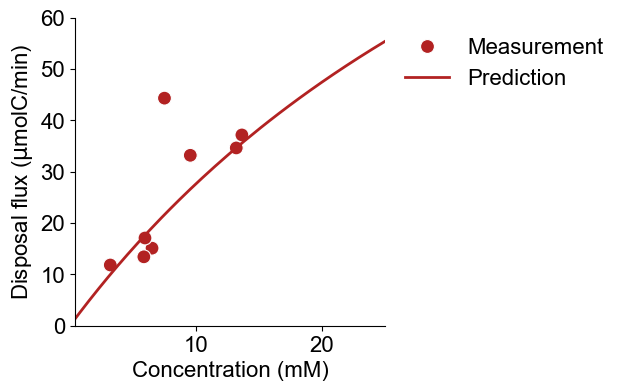

In [15]:
# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})

colors_met = ['firebrick', 'lightcoral', 'darkgoldenrod',]

# Rename labels glucose, lactate, 3HB
order = ['Glucose', ] 

df_joined_temp = df_joined[df_joined['COMPOUND'].isin(order)]
# Scatter plot of delta RD and delta CO2 flux
f, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(data=df_joined_temp, x='concentration_mM', y='RD' ,
                hue='COMPOUND', 
                palette=colors_met, s=100, hue_order=order, )
# Plot the model 

order = ['Glucose', ]

for i, met in enumerate(order):
    # Get the data for the current metabolite
    data = results[met]
    if met == 'Glucose':
        # Plot the model
        r1 = np.array([d[met] for d in data])  * vE  * scaling[met] / 1000 * 25
        r2 = np.array([d['Glycolysis'] for d in data])  * vE  * scaling['Glycolysis'] / 1000 * 25
        ax.plot(X * concentration_scaling[met], r1 + r2, color=colors_met[i],  linewidth=2, label='Prediction')


plt.ylim(0, 60)
plt.xlim(4e-1, 25)

# Rename first legen entry:
handles, labels = ax.get_legend_handles_labels()
new_labels = labels.copy()
new_labels[0] = 'Measurement'



sns.despine()
#plt.xscale('log')
plt.xlabel('Concentration (mM)')
plt.ylabel('Disposal flux ($\mathrm{\mu}$molC/min)')

plt.legend(handles, new_labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.savefig('./output/concentration_RD_flux.svg',  bbox_inches='tight')

# Save the data 

In [ ]:
# Compute mean error between model and data for CO2 and RD
c_order = ['Glucose', 'Lactate', 'Fatty acids','3HB',]

# Map tracer to model 
tracer_mapping = {
    'Glucose': 'Glucose',
    'Lactate': 'Lactate',
    'Fatty acids': 'Fatty acids',
    '3HB': 'Ketones',
}

KI_F = 0.2
p_fited = ref_parameters( KI_F = KI_F)

# Compute the fluxes using the relative concentrations as input data
results = []
index = []
for g in df.groupby(['TRACER','CAGE','DAY']).groups:
    # Get the data for the current group
    data = df.groupby(['TRACER','CAGE','DAY']).get_group(g)
    data.index = data.COMPOUND 

    x = data.loc[c_order,'value_normalized'].values 

    # Compute insulin value
    Imax = 1.0
    G = data.loc['Glucose','value_normalized'] 
    I = abs(G)**k / (abs(G)**k + C**k)
    x = np.append(x, I)
    
    # x -> data
    v = competitive_oxidation(x, p,)
    v = pd.Series(v, index=rate_names) * vE / 1000 * 25 # -> 25g Mouse 

    if g[0] == 'Glucose':
        r1 = v['Glucose'] * scaling[met] 
        r2 = v['Glycolysis'] * scaling[met] 
        # Total glucose oxidation
        results.append(r1 + r2)
    elif g[0] == '3HB':
        # Ketone oxidation
        r = v['Ketones'] * scaling[met] 
        results.append(r*0.5)
    else:
        # Other oxidation
        r = v[g[0]] * scaling[met] 
        results.append(r)

    # index g 
    index.append(g)


# Convert to dataframe
df_results = pd.DataFrame(results)
df_results.columns = ['predicted_flux']
# Add columns for G 
df_results['TRACER'] = [i[0] for i in index]
df_results['CAGE'] = [i[1] for i in index]
df_results['DAY'] = [i[2] for i in index]


[1.2814912  1.03511734 0.9059057  0.8680993  0.1204042 ]
[ 0.75233481  1.27494762  1.03176881 11.60882594  0.02189322]
[0.9953401  0.9563323  0.95182038 0.97241694 0.05479662]
[5.02460561e-01 8.67887260e-01 7.11526842e-01 1.09835475e+01
 5.64176461e-03]
[0.87528575 0.74165601 0.88232409 1.36524397 0.03609677]
[ 0.67629262  1.16016532  0.96059377 14.3839637   0.01534153]
[1.14204828 0.93189134 1.00528954 0.45434    0.08468797]
[1.18377753 1.03950166 0.92041534 1.00381453 0.09463807]
[2.39883028 1.29471414 0.35964496 0.04299338 0.53570044]
[1.0821428  0.92829368 1.10391736 1.06808351 0.0715258 ]
[2.48022238 1.16848673 0.40077456 0.06529887 0.56377399]
[0.58144968 0.6009068  0.76228495 0.8403687  0.00923501]
[1.36319491 1.2813251  0.57390138 0.10653087 0.14449276]
[1.06597664 0.90587076 1.00037124 1.36614671 0.06820085]
[1.73574125 1.20600039 0.47790503 0.0769469  0.27747653]
[1.04845366 1.29648892 1.20787238 1.46442939 0.06470549]
[0.9105488  2.54252866 0.67339651 0.20792258 0.04107168]


In [17]:
# Join with the flux data
df_joined = df_results.merge(df_fcirc, left_on=['TRACER', 'CAGE','DAY'], 
                     right_on=['TRACER_x', 'CAGE','DAY'], how='inner')

# Drop duplicated columns 
duplicaated_cols = df_joined.columns.duplicated()
df_joined = df_joined.loc[:, ~duplicaated_cols]



In [18]:
# Compute MSQ 
df_joined['RD'] = df_joined['RD'].astype(float)
df_joined['CO2_FLUX_NORM'] = df_joined['CO2_FLUX_NORM'].astype(float)
df_joined['predicted_flux'] = df_joined['predicted_flux'].astype(float)



In [19]:
# Compute a combined R2 using CO2 for lactate and 3HB and RD for glucose
MSE_combined = df_joined.apply(lambda x: np.mean((x['predicted_flux'] - (x['CO2_FLUX_NORM'] if x['TRACER_x'] != 'Glucose' else x['RD']))**2), axis=1).mean()
SP_combined = df_joined.apply(lambda x: np.mean(((x['CO2_FLUX_NORM'] if x['TRACER_x'] != 'Glucose' else x['RD']))**2), axis=1).mean()
R2 = 1 - MSE_combined/SP_combined

R2

0.9297536759075681

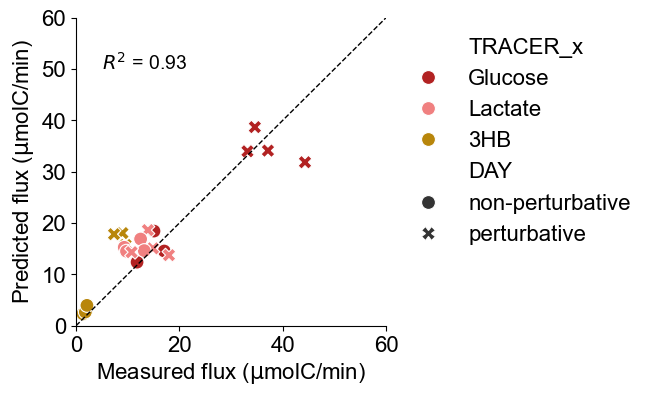

In [20]:
# Make scatter plot the predicted vs measured fluxes considering  CO2 for lactate and 3HB and RD for glucose
df_joined['measured_flux'] = df_joined.apply(lambda x: x['CO2_FLUX_NORM'] if x['TRACER_x'] != 'Glucose' else x['RD'], axis=1)
hue_order = ['Glucose', 'Lactate', '3HB',]
f, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(data=df_joined, x='measured_flux', y='predicted_flux' ,
                hue='TRACER_x',hue_order=hue_order,
                style='DAY',
                palette=colors_met, s=100,  )
plt.plot([0, 60], [0, 60], color='black', linestyle='--', linewidth=1)


plt.xlim(0, 60)
plt.ylim(0, 60)
plt.xlabel('Measured flux ($\mathrm{\mu}$molC/min)')
plt.ylabel('Predicted flux ($\mathrm{\mu}$molC/min)')

# Legend outside
plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
sns.despine()

# Annotate with R2 value
ax.text(5, 50, f'$R^2$ = {R2:.2f}', fontsize=14)

plt.savefig('./output/predicted_vs_measured_flux.svg',  bbox_inches='tight')